<a href="https://colab.research.google.com/github/pachterlab/Clytia_single_cell_2020/blob/master/notebooks/Preprocessing/ClickTagDemultiplexing/cellRangerClickTagCounts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Sat Dec  5 01:21:00 UTC 2020


In [1]:
!pip install --quiet pysam
!pip install --quiet scanpy
!pip install --quiet fuzzywuzzy
!pip install --quiet biopython

     |████████████████████████████████| 10.0MB 5.4MB/s 
     |████████████████████████████████| 7.7MB 5.6MB/s 
     |████████████████████████████████| 122kB 46.2MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 2.3MB 4.5MB/s 


In [2]:
#70BPbarcodes (ClickTag sequences)
!wget --quiet https://caltech.box.com/shared/static/hj4no50kc20482oq07rju098pap1i98h

#tags1.bam
!wget --quiet https://caltech.box.com/shared/static/sskkop3866ajhswyq8ibhup7gdork2gp

#tags2.bam
!wget --quiet https://caltech.box.com/shared/static/loqzj4lrf562mnk2hu2n02a7amj7t04f

In [3]:
import pysam
import os
import csv
import pandas
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from Bio import SeqIO
import time
import copy
import matplotlib.pyplot as plt
import scipy.io
import seaborn as sns
from collections import Counter
from collections import defaultdict
from collections import OrderedDict
from itertools import islice
from itertools import combinations
import pandas as pd
import time
import locale
#import Levenshtein
import re
import scanpy as sc
import multiprocessing

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
## Set parameters - below are parameters for 10x 3' v2 chemistry

cell_barcode_length = 16
UMI_length = 10

!mv hj4no50kc20482oq07rju098pap1i98h 70BPbarcodes.fa
!mv sskkop3866ajhswyq8ibhup7gdork2gp tags1.bam
!mv loqzj4lrf562mnk2hu2n02a7amj7t04f tags2.bam
tags = "70BPbarcodes.fa"
CellRangerOut = "tags1.bam"



In [5]:

def parse_tags(filename):
    odict = OrderedDict()
    for record in SeqIO.parse(filename, "fasta"):
        #odict[row[0].encode('utf-8')] = row[1]
        odict[record.name] = str(record.seq)[28:36]
    return odict


def worker(procnum, unique_lines_full, start, end, celltags, cellbarcodes, return_list):
    """worker function"""
    full_dataframe=pd.DataFrame(index=ab_map.keys(), columns=set([x[:16] for x in unique_lines_full]))
    full_dataframe.fillna(0, inplace=True)
    #variables
    res_table = defaultdict(lambda : defaultdict(int))
    n=0
    for line in unique_lines_full[start:end]:
        cell_barcode = line[0:cell_barcode_length]
        UMI = line[cell_barcode_length:cell_barcode_length+UMI_length]
        BC_UMI = cell_barcode + UMI
        TAG_seq = line[len(BC_UMI):]
        tagpositions = [TAG_seq[i:(i+23)] for i in range(0,10)]
        fuzzpos = process.extractOne("TCGTCGGCAGCGTCAGATGTGTA", tagpositions)
        if fuzzpos[1] > 85:

            pos = TAG_seq.find(fuzzpos[0])
            fuzzbc = process.extractOne(TAG_seq[pos+23:pos+31], list(ab_map.values()))
            if fuzzbc[1] > 85:
                best = list(ab_map.keys())[list(ab_map.values()).index(fuzzbc[0])]
                BC_UMI_TAG = BC_UMI + best
                if BC_UMI_TAG not in UMI_reduce:
                    #print("got one")
                    res_table[cell_barcode][best]+=1
                    full_dataframe.loc[best,cell_barcode]+=1
                    #print(full_dataframe.loc[best,cell_barcode])
                    UMI_reduce.add(BC_UMI_TAG)
        n += 1
        #if(n>5):break
        if(n%20000==0):
            print(n)
            print("elapsed time " + str(time.time()-start))
    if procnum < 5:
        print('hello_world '+cell_barcode)
        print(full_dataframe.loc[:,cell_barcode])
        #put res_table into dataframe
        """worker function"""
        print('worker '+str(procnum) + '\t' + 'start '+str(start) + '\t' + 'end '+str(end))
        print(pd.DataFrame(res_table))
        print(' ')
    return_list.append(full_dataframe)
    return



In [6]:
ab_map=parse_tags(tags)

In [7]:
ab_map

OrderedDict([('BC_21', 'AGCAGTTA'),
             ('BC_22', 'CTTGTACC'),
             ('BC_23', 'GAACCCGG'),
             ('BC_24', 'TCGTAGAT'),
             ('BC_25', 'ACGCGGAA'),
             ('BC_26', 'CGCTATCC'),
             ('BC_27', 'GTTGCATG'),
             ('BC_28', 'TAAATCGT'),
             ('BC_29', 'ATCGCCAT'),
             ('BC_30', 'CATAAAGG'),
             ('BC_31', 'TCACGGTA'),
             ('BC_32', 'CACTCAAC'),
             ('BC_33', 'GCTGTGTA'),
             ('BC_34', 'TTGCGTCG'),
             ('BC_35', 'ATATGAGA'),
             ('BC_36', 'CACCTCAG'),
             ('BC_37', 'GCTACTTC'),
             ('BC_38', 'TGGGAGCT'),
             ('BC_39', 'ATCCGGCA'),
             ('BC_40', 'CCGTTATG')])

### Count ClickTags lane 1 tags first

In [8]:
"Create a set for UMI reduction. Fast way to collapse UMIs"

UMI_reduce=set()
#Creaet result table
res_table=defaultdict(lambda : defaultdict(int))
#set counter
n=0
#set number of reads to process
top_n = None

In [9]:
"""
This section of code processes the entire genome BAM file. Runtime is about one hour for 3 million reads.
Proccessing is slow due to multiple fuzzy matching steps
Currently configured for 10x v2 and sample tags used in Gehring et. al 2018
The script iterates through the genome BAM, identifies quality barcode sequences with fuzzywuzzy score > 85, 
then classifies them.
fuzzpos is a constant sequence just upstream of the barcode
fuzzbc is the barcode sequence extracted for classification
"""

#Load TAGS barcodes
ab_map = parse_tags(tags)
#Create a set for UMI reduction. Fast way to check if it already exists
UMI_reduce = set()
#Create result table
res_table = defaultdict(lambda : defaultdict(int))
res_table_sum = defaultdict(lambda : defaultdict(int))
# set counter
n = 0
top_n = None
unique_lines = set()
start = time.time()

samfile = pysam.AlignmentFile(CellRangerOut, "rb")
for read in samfile.fetch(until_eof=True):
    if read.has_tag('CB'):
        line = str(read.get_tag('CB'))[:-2] + read.get_tag('UR') + str(read.query_sequence)
        unique_lines.add(line)    
    if top_n: 
        if top_n < n: break
    n += 1
    if(n%1000000==0):print(n)
    if(n%1000000==0):
        print('elapsed time: ' + str(time.time()-start))
samfile.close()
print(str(n) + ' reads loaded')
print(str(len(unique_lines)) + ' unique reads loaded')

    
    
print("runtime " + str(time.time() - start))

1000000
elapsed time: 4.636726379394531
2000000
elapsed time: 10.57099962234497
3000000
elapsed time: 16.400855779647827
4000000
elapsed time: 22.376185178756714
5000000
elapsed time: 28.265373945236206
6000000
elapsed time: 34.18254280090332
7000000
elapsed time: 40.31838536262512
8000000
elapsed time: 46.209506034851074
9000000
elapsed time: 52.144378900527954
10000000
elapsed time: 58.420165061950684
10090668 reads loaded
9626566 unique reads loaded
runtime 59.00274896621704


In [10]:
# unique_lines = list(unique_lines)
# #unique_lines

In [ ]:
unique_lines = list(unique_lines)

jobs=[]
manager = multiprocessing.Manager()
return_list = manager.list()
n_threads=2
slicestart=0
celltags=list(ab_map.keys())
cellbarcodes=list(set([x[:16] for x in unique_lines]))

for job in range(n_threads):
    #divide up the unique_lines by the number of threads
    #call the worker function, passing positions in unique_lines as input
    sliceend=slicestart+len(unique_lines)//n_threads #len(unique_lines)
    p = multiprocessing.Process(target=worker, args=(job, unique_lines,slicestart, sliceend, celltags, cellbarcodes, return_list))
    jobs.append(p)
    p.start()
    slicestart=sliceend

for p in jobs:
  p.join()

20000
elapsed time 1608309426.4472153
20000
elapsed time 1603496145.4360516
40000
elapsed time 1608309622.820505
40000
elapsed time 1603496342.4276586
60000
elapsed time 1608309822.6932628
60000
elapsed time 1603496544.1234446
80000
elapsed time 1608310019.5178154
80000
elapsed time 1603496742.1021395
100000
elapsed time 1608310216.6301436
100000
elapsed time 1603496939.6002922
120000
elapsed time 1608310413.4286246
120000
elapsed time 1603497136.6886392
140000
elapsed time 1608310609.073119
140000
elapsed time 1603497332.7455747
160000
elapsed time 1608310805.276078
160000
elapsed time 1603497529.5186045
180000
elapsed time 1608311001.5677764
180000
elapsed time 1603497725.5921671
200000
elapsed time 1608311198.3779976
200000
elapsed time 1603497920.9305139
220000
elapsed time 1608311397.0302124
220000
elapsed time 1603498116.665191
240000
elapsed time 1603498311.8906798
240000
elapsed time 1608311595.1122336
260000
elapsed time 1603498508.5195475
260000
elapsed time 1608311793.958501

In [13]:
return_list = list(return_list) 
print(return_list)

[       CTCTAATGTCCGTGAC  TCAACGACAACTGGCC  ...  GAATGAATCCTTGGTC  CTAATGGCACTGTTAG
BC_21                 0                 0  ...                 0                 0
BC_22                 0                 0  ...                 0                 0
BC_23                 0                 0  ...                 0                 0
BC_24                 0                 0  ...                 0                 0
BC_25                 0                 0  ...                 0                 0
BC_26                 0                 0  ...                 0                 0
BC_27                 0                 0  ...                 0                 0
BC_28                 0                 0  ...                 0                 0
BC_29                 0                 0  ...                 0                 0
BC_30                 0                 0  ...                 0                 0
BC_31                 0                 0  ...                 0                 0
BC_

In [ ]:
# unique_lines_full = unique_lines
# return_list = []
# #n_threads=80
# start=0
# end = start+len(unique_lines) 
# celltags=list(ab_map.keys())
# cellbarcodes=list(set([x[:16] for x in unique_lines_full]))
# procnum = 1

# full_dataframe=pd.DataFrame(index=ab_map.keys(), columns=set([x[:16] for x in unique_lines_full]))
# full_dataframe.fillna(0, inplace=True)
# #variables
# res_table = defaultdict(lambda : defaultdict(int))
# n=0
# for line in unique_lines_full: #[start:end]
#   cell_barcode = line[0:cell_barcode_length]
#   UMI = line[cell_barcode_length:cell_barcode_length+UMI_length]
#   BC_UMI = cell_barcode + UMI
#   TAG_seq = line[len(BC_UMI):]
#   tagpositions = [TAG_seq[i:(i+23)] for i in range(0,10)]
#   fuzzpos = process.extractOne("TCGTCGGCAGCGTCAGATGTGTA", tagpositions)
#   if fuzzpos[1] > 85:

#     pos = TAG_seq.find(fuzzpos[0])
#     fuzzbc = process.extractOne(TAG_seq[pos+23:pos+31], list(ab_map.values()))
#     if fuzzbc[1] > 85:
#       best = list(ab_map.keys())[list(ab_map.values()).index(fuzzbc[0])]
#       BC_UMI_TAG = BC_UMI + best
#       if BC_UMI_TAG not in UMI_reduce:
#         #print("got one")
#         res_table[cell_barcode][best]+=1
#         full_dataframe.loc[best,cell_barcode]+=1
#         #print(full_dataframe.loc[best,cell_barcode])
#         UMI_reduce.add(BC_UMI_TAG)
#   n += 1
#   #if(n>5):break
#   if(n%20000==0):
#     print(n)
#     print("elapsed time " + str(time.time()-start))

# return_list.append(full_dataframe)

In [ ]:
# procnum = 1
# if procnum < 5:
#   print('hello_world '+cell_barcode)
#   print(full_dataframe.loc[:,cell_barcode])
#   #put res_table into dataframe
#   """worker function"""
#   print('worker '+str(procnum) + '\t' + 'start '+str(start) + '\t' + 'end '+str(end))
#   print(pd.DataFrame(res_table))
#   print(' ')
# return_list.append(full_dataframe)

In [ ]:
# print(return_list)

In [ ]:
pd.DataFrame(res_table)
return_list[0][0].fillna(0).iloc[:]['ATCATCTCATCACGTA'] = return_list[0][0].fillna(0).iloc[:]['ATCATCTCATCACGTA']+return_list[0][0].fillna(0).iloc[:]['ATCATCTCATCACGTA']
return_list[0][0].fillna(0).loc[:,'ATCATCTCATCACGTA']  #*****RETURNING ERROR (empty) ****

In [ ]:
final_df=pd.DataFrame(index=ab_map.keys(), columns=set([x[:16] for x in unique_lines]))
final_df.fillna(0,inplace=True)
for i in range(len(return_list)):
    final_df+=(return_list[i])

In [ ]:
final_df.head()

,GCATGCGGTAGGGTAC,GCGAGAATCTTGACGA,CAGCATAGTTCCGGCA,CGATGGCCAGCTCGAC,AGTGAGGCATGCAACT,CCTACCATCATAAAGG,TTGTAGGCAGTTCCCT,ACCGTAAAGACAGGCT,GACTGCGTCCCTCAGT,TGGGAAGAGCTGGAAC,TCCACACAGGATTCGG,TTAGGCACACCGGAAA,ACGATACGTGGTTTCA,AGCGTATAGCGAGAAA,GTACTTTGTCTGCAAT,TGCCAAACAAGCTGAG,ACGGGTCTCTTGACGA,ACTTACTAGGAGTCTG,TAGGCATTCGCCAAAT,CGTTGGGCAAATCCGT,CGATGTATCACCCTCA,AAGACCTAGGGCACTA,TCAGATGTCTGTACGA,CCCAATCCACCACCAG,GCATACAGTTATGTGC,GGGAATGTCGCCCTTA,CATGACAAGTCGCCGT,ATCCGAAAGCAACGGT,CTTAGGATCATTGCCC,GCATGTAGTCCTGCTT,CATCAAGTCGCGTTTC,TACAGTGTCTAACTGG,GGAAAGCAGAATGTGT,AATCCAGCACCTGGTG,GCGCAACGTGCTAGCC,CGATGGCCACGGCCAT,GCAGCCATCGGAGCAA,AACTCTTGTACCGTAT,CACCACTCAGCTGTTA,GTCGTAACAGTCAGAG,...,AGATTGCCAACCGCCA,ATAGACCGTACAGTGG,AGCGTATGTAAATACG,TTTATGCGTCGGCATC,TCAGGATGTGAAATCA,TCTATTGGTTAAGAAC,GATCGATCAGTTTACG,CGCTTCAGTTTGACAC,TATTACCTCATCTGTT,CTACCCAGTACTCTCC,ACGCCGACAGCTGTAT,CCATGTCGTTGGGACA,CGATGTAGTCGACTAT,CGTTCTGAGGAGCGAG,CATGCCTTCTCAAACG,GGACAGATCTCGCATC,CGCCAAGTCCAAAGTC,CTAGAGTAGATGGCGT,TCGGTAATCCTCGCAT,TACTCGCCATTTGCTT,GCTGCAGTCAGGCCCA,ATAGACCTCTAACTCT,CAGGTGCAGGACATTA,CCTTCCCGTTCACGGC,TTAGTTCGTCCTCTTG,ACGGGCTTCCCTAATT,CCTATTACAGTAAGAT,TGTATTCCACACCGCA,CTGTTTAAGGCCGAAT,TACAGTGGTGTAACGG,CGATGTACATGTAGTC,GCGCAGTCACGGACAA,AAAGCAATCAATCACG,AAGCCGCTCATCGCTC,CTAATGGAGCCCAACC,GGTGTTAGTGGACGAT,ACTGATGTCTCAACTT,TAAGAGATCCGCGTTT,AAACGGGTCTGCGGCA,GCTTCCACAAAGGAAG
BC_21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BC_22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BC_23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BC_24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BC_25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


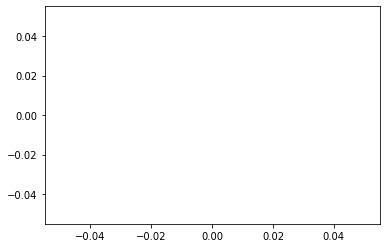

In [ ]:
res_matrix=copy.deepcopy(final_df)
sortedREAP_dtf = copy.deepcopy(res_matrix.sum())
sortedREAP_dtf = sortedREAP_dtf.sort_values(ascending=False)
plt.plot(np.log10(range(len(sortedREAP_dtf))), sortedREAP_dtf.apply(np.log10))
plt.show()

In [ ]:
"""
Have a look at the data
Columns of the matrix are cells
Rows are tag counts for each cell
Only 8 of twenty possible tags were used in this experiment (2 tags for each of 4 samples)
"""
res_matrix.fillna(0, inplace=True)
res_matrix.loc[:,sortedREAP_dtf.index[6000:6020]]

,CCACGGACAGGATTGG,CGGACGTAGCACCGCT,ATCACGAAGCCCAACC,AGTGTCACAATCACAC,CGGCTAGAGGCTCTTA,ACACCAAGTGAGGCTA,CGTCACTAGCTAGTCT,TCAGGTACACTTCTGC,CACACTCAGACAATAC,TGCGTGGCAATGCCAT,TTTGCGCTCAGCGACC,GGTGTTATCCGAACGC,CGAATGTCATCAGTAC,CTCATTAAGAGCCTAG,ACTGTCCGTGACCAAG,CATGCCTCACAGCGTC,CTCGTACAGGCATTGG,TCAGATGTCCCATTAT,CAAGAAAGTTATGTGC,CTCTGGTAGATATGGT
BC_21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BC_22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BC_23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BC_24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BC_25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BC_26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BC_27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BC_28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BC_29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BC_30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
res_matrix.to_csv(path_or_buf="jelly3tags1counts.csv")

### Analysis for lane 2 ClickTags

In [ ]:
CellRangerOut = "tags2.bam"

In [ ]:
"Create a set for UMI reduction. Fast way to collapse UMIs"

UMI_reduce=set()
#Creaet result table
res_table=defaultdict(lambda : defaultdict(int))
#set counter
n=0
#set number of reads to process
top_n = None

In [ ]:
"""
This section of code processes the entire genome BAM file. Runtime is about one hour for 3 million reads.
Proccessing is slow due to multiple fuzzy matching steps
Currently configured for 10x v2 and sample tags used in Gehring et. al 2018
The script iterates through the genome BAM, identifies quality barcode sequences with fuzzywuzzy score > 85, 
then classifies them.
fuzzpos is a constant sequence just upstream of the barcode
fuzzbc is the barcode sequence extracted for classification
"""

#Load TAGS barcodes
ab_map = parse_tags(tags)
#Create a set for UMI reduction. Fast way to check if it already exists
UMI_reduce = set()
#Create result table
res_table = defaultdict(lambda : defaultdict(int))
res_table_sum = defaultdict(lambda : defaultdict(int))
# set counter
n = 0
top_n = None
unique_lines = set()
start = time.time()

samfile = pysam.AlignmentFile(CellRangerOut, "rb")
for read in samfile.fetch(until_eof=True):
    if read.has_tag('CB'):
        line = str(read.get_tag('CB'))[:-2] + read.get_tag('UR') + str(read.query_sequence)
        unique_lines.add(line)    
    if top_n: 
        if top_n < n: break
    n += 1
    if(n%1000000==0):print(n)
    if(n%1000000==0):
        print('elapsed time: ' + str(time.time()-start))
samfile.close()
print(str(n) + ' reads loaded')
print(str(len(unique_lines)) + ' unique reads loaded')

    
    
print("runtime " + str(time.time() - start))

1000000
elapsed time: 4.658763885498047
2000000
elapsed time: 10.726136445999146
3000000
elapsed time: 16.86853003501892
4000000
elapsed time: 22.890313625335693
5000000
elapsed time: 28.802430152893066
6000000
elapsed time: 35.0033597946167
7000000
elapsed time: 41.18895173072815
8000000
elapsed time: 47.19905686378479
9000000
elapsed time: 53.172648429870605
10000000
elapsed time: 59.088330030441284
10090668 reads loaded
9626566 unique reads loaded
runtime 59.633803844451904


In [ ]:
unique_lines = list(unique_lines)

jobs=[]
manager = multiprocessing.Manager()
return_list = manager.list()
n_threads=80
slicestart=0
celltags=list(ab_map.keys())
cellbarcodes=list(set([x[:16] for x in unique_lines]))
for job in range(n_threads):
    #divide up the unique_lines by the number of threads
    #call the worker function, passing positions in unique_lines as input
    sliceend=slicestart+len(unique_lines)//n_threads
    p = multiprocessing.Process(target=worker, args=(job, unique_lines,slicestart, sliceend, celltags, cellbarcodes, return_list))
    jobs.append(p)
    p.start()
    slicestart=sliceend

In [ ]:
pd.DataFrame(res_table)
return_list[0][0].fillna(0).iloc[:]['ATCATCTCATCACGTA'] = return_list[0][0].fillna(0).iloc[:]['ATCATCTCATCACGTA']+return_list[0][0].fillna(0).iloc[:]['ATCATCTCATCACGTA']
return_list[0][0].fillna(0).loc[:,'ATCATCTCATCACGTA']

In [ ]:
final_df=pd.DataFrame(index=ab_map.keys(), columns=set([x[:16] for x in unique_lines]))
final_df.fillna(0,inplace=True)
for i in range(len(return_list)):
    final_df+=(return_list[i])

In [ ]:
final_df.head()

In [ ]:
res_matrix=copy.deepcopy(final_df)
sortedREAP_dtf = copy.deepcopy(res_matrix.sum())
sortedREAP_dtf = sortedREAP_dtf.sort_values(ascending=False)
plt.plot(np.log10(range(len(sortedREAP_dtf))), sortedREAP_dtf.apply(np.log10))
plt.show()

In [ ]:
"""
Have a look at the data
Columns of the matrix are cells
Rows are tag counts for each cell
Only 8 of twenty possible tags were used in this experiment (2 tags for each of 4 samples)
"""
res_matrix.fillna(0, inplace=True)
res_matrix.loc[:,sortedREAP_dtf.index[5000:5200]]

In [ ]:
res_matrix.to_csv(path_or_buf="jelly3tags2counts.csv")